Найдено изображений: 5
Обработка: 5plan.jpg
Результат сохранен: output/5plan.json
Статистика:
  - Всего стен: 38
       • horizontal: 26
       • vertical: 12
     - Дверей: 12
------------------------------
Обработка: 4plan.jpg
Результат сохранен: output/4plan.json
Статистика:
  - Всего стен: 135
       • horizontal: 84
       • vertical: 43
       • diagonal: 4
       • other: 4
     - Дверей: 12
------------------------------
Обработка: 6plan.jpg
Результат сохранен: output/6plan.json
Статистика:
  - Всего стен: 135
       • horizontal: 84
       • vertical: 43
       • diagonal: 4
       • other: 4
     - Дверей: 12
------------------------------
Обработка: 2plan.jpg
Результат сохранен: output/2plan.json
Статистика:
  - Всего стен: 66
       • horizontal: 49
       • vertical: 17
     - Дверей: 6
------------------------------
Обработка: 3plan.jpeg
Результат сохранен: output/3plan.json
Статистика:
  - Всего стен: 85
       • horizontal: 49
       • vertical: 36
     - Дверей: 7
----

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


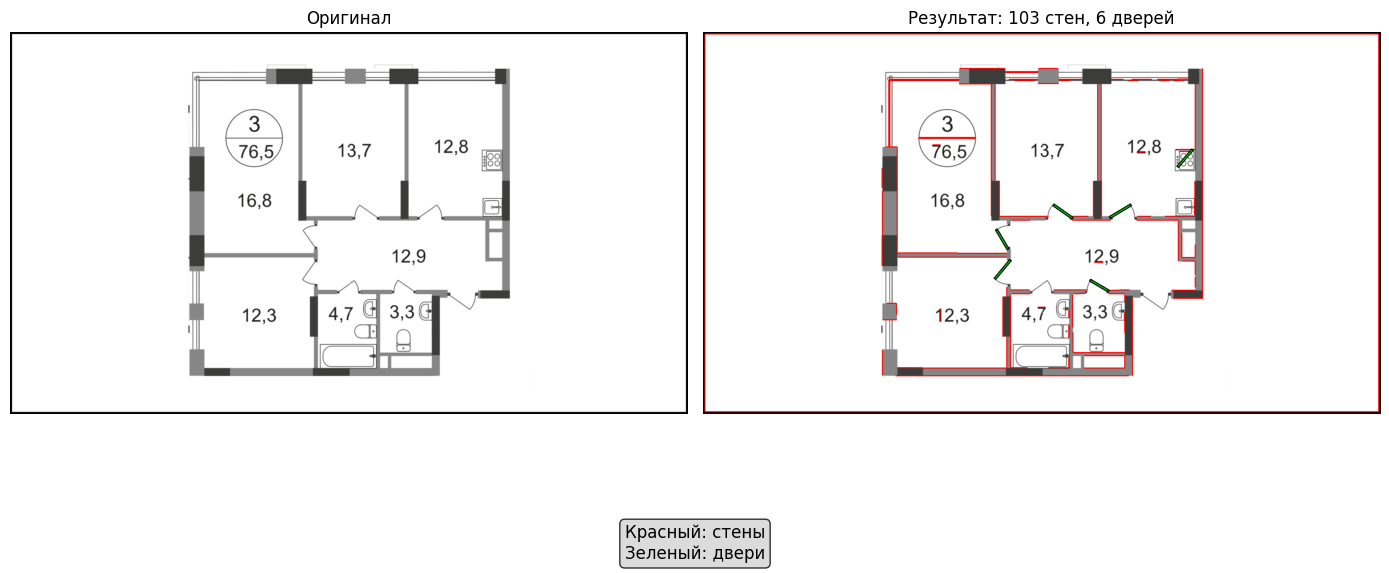

In [82]:
import cv2
import numpy as np
import json
import os
from pathlib import Path

class FloorplanParser:
    """
    Парсер планов с детекцией линий
    """
    
    def __init__(self):
        # Параметры для детекции стен
        self.wall_params = {
            'min_length': 20,    # Минимальная длина линии
            'threshold': 50,     # Чувствительность
            'max_gap': 5         # Разрешаем небольшие разрывы
        }
    
    def preprocess_image(self, image):
        """
        Простая предобработка изображения
        """
        # 1. Конвертация в grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # 2. Улучшаем контраст
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(gray)
        
        # 3. Бинаризация
        _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        # 4. Морфологическая очистка
        kernel = np.ones((3, 3), np.uint8)
        cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)
        
        return cleaned
    
    def detect_all_lines(self, binary_image):
        """
        Детекция всех линий
        """
        # Детекция краев
        edges = cv2.Canny(binary_image, 50, 150)
        
        # Детекция линий Хафа
        lines = cv2.HoughLinesP(
            edges,
            rho=1,
            theta=np.pi/180,
            threshold=self.wall_params['threshold'],
            minLineLength=self.wall_params['min_length'],
            maxLineGap=self.wall_params['max_gap']
        )
        
        walls = []
        
        if lines is not None:
            for i, line in enumerate(lines):
                x1, y1, x2, y2 = line[0]
                
                # Вычисляем длину
                length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                
                # Вычисляем угол
                if x2 - x1 == 0:
                    angle = 90
                else:
                    angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
                angle = angle % 180
                
                # Определяем тип линии
                if (angle < 15) or (angle > 165):
                    line_type = "horizontal"
                elif (75 < angle < 105):
                    line_type = "vertical"
                elif (30 < angle < 60) or (120 < angle < 150):
                    line_type = "diagonal"
                else:
                    line_type = "other"
                
                walls.append({
                    "id": f"w{i+1}",
                    "points": [[int(x1), int(y1)], [int(x2), int(y2)]],
                    "length": float(length),
                    "angle": float(angle),
                    "type": line_type
                })
        
        return walls
    
    def detect_doors(self, image, walls):
        """
        Ищем короткие диагональные линии (двери) с проверкой примыкания к стенам
        """
        doors = []

        # Улучшенная предобработка для поиска дверей
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Усиливаем контраст для лучшего обнаружения линий
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(gray)

        # Детекция краев с разными параметрами
        edges1 = cv2.Canny(enhanced, 30, 100)  # Для тонких линий
        edges2 = cv2.Canny(enhanced, 50, 150)  # Для толстых линий
        edges = cv2.bitwise_or(edges1, edges2)  # Объединяем

        # Морфология для соединения разрывов в линиях
        kernel = np.ones((2, 2), np.uint8)
        edges = cv2.dilate(edges, kernel, iterations=1)

        # Ищем линии с разными параметрами
        lines1 = cv2.HoughLinesP(
            edges,
            rho=1,
            theta=np.pi/180,
            threshold=20,  # Более низкий порог
            minLineLength=25,
            maxLineGap=5
        )

        lines2 = cv2.HoughLinesP(
            edges,
            rho=1,
            theta=np.pi/180,
            threshold=30,
            minLineLength=30,
            maxLineGap=3
        )

        # Объединяем линии
        all_lines = []
        if lines1 is not None:
            all_lines.extend(lines1)
        if lines2 is not None:
            all_lines.extend(lines2)

        if not all_lines:
            return doors

        # Создаем маску стен для проверки примыкания
        wall_mask = np.zeros_like(gray)
        for wall in walls:
            pts = wall['points']
            if len(pts) >= 2:
                cv2.line(wall_mask, tuple(pts[0]), tuple(pts[1]), 255, 3)

        for i, line in enumerate(all_lines):
            x1, y1, x2, y2 = line[0]

            # Вычисляем длину линии
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

            # Вычисляем угол линии
            if x2 - x1 == 0:
                angle = 90
            else:
                angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
            angle = angle % 180

            # ФИЛЬТР 1: Только диагональные линии
            # Не горизонтальные (0° ± 30°) и не вертикальные (90° ± 30°)
            is_horizontal = (angle < 30) or (angle > 150)
            is_vertical = (60 < angle < 120)
            is_diagonal = not (is_horizontal or is_vertical)

            # ФИЛЬТР 2: Длина подходящая для двери
            # Двери обычно короче стен
            is_short = 25 < length < 80

            if is_diagonal and is_short:
                # ФИЛЬТР 3: Проверяем, что линия примыкает к стене
                touches_wall, wall_angle = self.door_touches_wall(line[0], wall_mask, walls)

                if touches_wall:
                    # Определяем тип стены, к которой примыкает дверь
                    if wall_angle is not None:
                        wall_type = "horizontal" if (abs(wall_angle) < 30 or abs(wall_angle) > 150) else "vertical"
                    else:
                        wall_type = "unknown"

                    # Определяем направление открытия двери
                    # (по углу относительно стены)
                    door_direction = self.get_door_direction(angle, wall_angle)

                    # Создаем дверь с учетом ее параметров
                    door = self.create_door_from_line(line[0], angle, length, wall_type, door_direction)
                    door["id"] = f"d{len(doors)+1}"

                    # Проверяем, что дверь не слишком похожа на уже найденные
                    if not self.is_similar_to_existing_door(door, doors):
                        doors.append(door)

        # Удаляем дубликаты и слишком близкие двери
        unique_doors = self.remove_duplicate_doors(doors)

        return unique_doors[:15]  # Ограничиваем количество

    def door_touches_wall(self, line, wall_mask, walls, max_distance=10):
        """
        Проверяет, примыкает ли линия (дверь) к стене
        Возвращает (примыкает_ли, угол_стены)
        """
        x1, y1, x2, y2 = line

        # Проверяем оба конца линии
        for end_point in [(x1, y1), (x2, y2)]:
            end_x, end_y = end_point

            # Проверяем область вокруг конца линии
            for dx in range(-max_distance, max_distance + 1):
                for dy in range(-max_distance, max_distance + 1):
                    check_x = int(end_x + dx)
                    check_y = int(end_y + dy)

                    # Проверяем границы
                    if (0 <= check_x < wall_mask.shape[1] and 
                        0 <= check_y < wall_mask.shape[0]):

                        # Если попадаем на стену
                        if wall_mask[check_y, check_x] > 0:
                            # Находим угол ближайшей стены
                            nearest_wall_angle = self.find_nearest_wall_angle(end_x, end_y, walls)
                            return True, nearest_wall_angle

        return False, None

    def find_nearest_wall_angle(self, x, y, walls, max_distance=20):
        """
        Находит угол ближайшей стены к точке (x, y)
        """
        min_distance = float('inf')
        nearest_angle = None

        for wall in walls:
            pts = wall['points']
            if len(pts) >= 2:
                w_x1, w_y1 = pts[0]
                w_x2, w_y2 = pts[1]

                # Расстояние от точки до стены
                distance = self.point_to_line_distance(x, y, w_x1, w_y1, w_x2, w_y2)

                if distance < min_distance and distance < max_distance:
                    min_distance = distance
                    # Вычисляем угол стены
                    if w_x2 - w_x1 == 0:
                        wall_angle = 90
                    else:
                        wall_angle = np.degrees(np.arctan2(w_y2 - w_y1, w_x2 - w_x1))
                    wall_angle = wall_angle % 180
                    nearest_angle = wall_angle

        return nearest_angle

    def get_door_direction(self, door_angle, wall_angle):
        """
        Определяет направление открытия двери относительно стены
        """
        if wall_angle is None:
            return "unknown"

        # Нормализуем углы
        door_angle_norm = door_angle % 180
        wall_angle_norm = wall_angle % 180

        # Разница углов
        angle_diff = abs(door_angle_norm - wall_angle_norm)
        angle_diff = min(angle_diff, 180 - angle_diff)

        # Дверь должна быть примерно под 45° к стене
        if 30 < angle_diff < 60:
            # Определяем в какую сторону открывается дверь
            relative_angle = (door_angle_norm - wall_angle_norm) % 360

            if 30 < relative_angle < 150:
                return "right"  # Открывается направо
            elif 210 < relative_angle < 330:
                return "left"   # Открывается налево
            else:
                return "center"

        return "unknown"

    def create_door_from_line(self, line, angle, length, wall_type, direction):
        """
        Создает объект двери из линии
        """
        x1, y1, x2, y2 = line

        # Толщина линии двери для визуализации
        door_thickness = 6

        # Вычисляем перпендикуляр для толщины
        dx = x2 - x1
        dy = y2 - y1
        line_len = max(np.sqrt(dx*dx + dy*dy), 0.1)

        dx /= line_len
        dy /= line_len

        # Перпендикулярный вектор
        perp_dx = -dy * (door_thickness / 2)
        perp_dy = dx * (door_thickness / 2)

        # 4 точки для параллелограмма (двери)
        points = [
            [int(x1 + perp_dx), int(y1 + perp_dy)],
            [int(x1 - perp_dx), int(y1 - perp_dy)],
            [int(x2 - perp_dx), int(y2 - perp_dy)],
            [int(x2 + perp_dx), int(y2 + perp_dy)]
        ]

        # Bounding box
        xs = [p[0] for p in points]
        ys = [p[1] for p in points]

        return {
            "bbox": [min(xs), min(ys), max(xs)-min(xs), max(ys)-min(ys)],
            "points": points,
            "endpoints": [[int(x1), int(y1)], [int(x2), int(y2)]],
            "angle": float(angle),
            "length": float(length),
            "wall_type": wall_type,
            "direction": direction,
            "type": "door"
        }

    def is_similar_to_existing_door(self, new_door, existing_doors, min_distance=15, max_angle_diff=20):
        """
        Проверяет, похожа ли новая дверь на уже существующие
        """
        new_center_x = new_door['bbox'][0] + new_door['bbox'][2] / 2
        new_center_y = new_door['bbox'][1] + new_door['bbox'][3] / 2
        new_angle = new_door['angle']

        for door in existing_doors:
            door_center_x = door['bbox'][0] + door['bbox'][2] / 2
            door_center_y = door['bbox'][1] + door['bbox'][3] / 2
            door_angle = door['angle']

            # Расстояние между центрами
            distance = np.sqrt((new_center_x - door_center_x)**2 + 
                              (new_center_y - door_center_y)**2)

            # Разница углов
            angle_diff = abs(new_angle - door_angle) % 180
            angle_diff = min(angle_diff, 180 - angle_diff)

            if distance < min_distance and angle_diff < max_angle_diff:
                return True

        return False

    def remove_duplicate_doors(self, doors, min_distance=20):
        """
        Удаляет дублирующиеся двери
        """
        if len(doors) <= 1:
            return doors

        unique_doors = []
        used_indices = set()

        for i in range(len(doors)):
            if i in used_indices:
                continue

            unique_doors.append(doors[i])
            used_indices.add(i)

            for j in range(i + 1, len(doors)):
                if j in used_indices:
                    continue

                # Сравниваем двери
                door1 = doors[i]
                door2 = doors[j]

                # Центры дверей
                x1 = door1['bbox'][0] + door1['bbox'][2] / 2
                y1 = door1['bbox'][1] + door1['bbox'][3] / 2

                x2 = door2['bbox'][0] + door2['bbox'][2] / 2
                y2 = door2['bbox'][1] + door2['bbox'][3] / 2

                distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

                # Если двери слишком близко - считаем дубликатами
                if distance < min_distance:
                    used_indices.add(j)

        return unique_doors
    
    def point_to_line_distance(self, px, py, x1, y1, x2, y2):
        """
        Вычисляет расстояние от точки (px, py) до отрезка (x1,y1)-(x2,y2)
        """
        # Если отрезок вырожден в точку
        if x1 == x2 and y1 == y2:
            return np.sqrt((px - x1)**2 + (py - y1)**2)

        # Вычисляем проекцию точки на линию
        line_length_sq = (x2 - x1)**2 + (y2 - y1)**2

        # Параметр t для проекции
        t = ((px - x1) * (x2 - x1) + (py - y1) * (y2 - y1)) / line_length_sq
        t = max(0, min(1, t))  # Ограничиваем отрезком

        # Координаты ближайшей точки на отрезке
        closest_x = x1 + t * (x2 - x1)
        closest_y = y1 + t * (y2 - y1)

        # Расстояние до ближайшей точки
        return np.sqrt((px - closest_x)**2 + (py - closest_y)**2)

    def process(self, image_path):
        """Основной пайплайн"""
        image = cv2.imread(str(image_path))
        if image is None:
            print(f"Ошибка загрузки: {image_path}")
            return None
        
        # 1. Предобработка
        binary = self.preprocess_image(image)
        
        # 2. Детекция всех линий
        walls = self.detect_all_lines(binary)
        
        # 3. Детекция дверей
        doors = self.detect_doors(image, walls)
        
        # Формирование результата
        result = {
            "meta": {
                "source": Path(image_path).name,
                "image_size": {
                    "width": int(image.shape[1]),
                    "height": int(image.shape[0])
                }
            },
            "walls": walls,
            "doors": doors
        }
        
        return result

def main():
    """Основная функция"""
    parser = FloorplanParser()
    
    input_dir = "plans"
    output_dir = "output"
    os.makedirs(output_dir, exist_ok=True)
    
    # Находим изображения
    images = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        images.extend(Path(input_dir).glob(ext))
    
    images = images[:5]  # Обрабатываем до 5 изображений
    
    if not images:
        print(f"В папке '{input_dir}' не найдены изображения")
        # Создаем тестовую папку с примером
        print("Создаю тестовую папку 'plans' с примером изображения...")
        os.makedirs("plans", exist_ok=True)
        return
    
    print(f"Найдено изображений: {len(images)}")
    print("=" * 50)
    
    for img_path in images:
        print(f"Обработка: {img_path.name}")
        
        result = parser.process(img_path)
        if result:
            output_path = Path(output_dir) / f"{img_path.stem}.json"
            with open(output_path, 'w', encoding='utf-8') as f:
                json.dump(result, f, indent=2, ensure_ascii=False)
            
            print(f"Результат сохранен: {output_path}")
            print(f"Статистика:")
            print(f"  - Всего стен: {len(result['walls'])}")
            
            # Статистика по типам стен
            types = {}
            for wall in result['walls']:
                t = wall.get('type', 'other')
                types[t] = types.get(t, 0) + 1
            
            for t, count in types.items():
                print(f"       • {t}: {count}")
            
            print(f"     - Дверей: {len(result.get('doors', []))}")
        
        print("-" * 30)
    
    print("Обработка завершена!")

# Простая визуализация
def visualize_results(image_path):
    """Визуализация оригинала и результата"""
    import matplotlib.pyplot as plt
    
    parser = FloorplanParser()
    
    image = cv2.imread(str(image_path))
    result = parser.process(image_path)
    
    if not result:
        print("Не удалось получить результат для визуализации")
        return
    
    original = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result_img = original.copy()
    
    # ЦВЕТА:
    WALL_COLOR = (255, 0, 0)      # Красный для стен (в RGB)
    DOOR_COLOR = (0, 255, 0)    # Зеленыц для дверей (в RGB)
    
    # Рисуем стены
    for wall in result.get('walls', []):
        pts = wall.get('points', [])
        if len(pts) >= 2:
            cv2.line(result_img, tuple(pts[0]), tuple(pts[1]), WALL_COLOR, 2)
    
    # Рисуем двери
    for door in result.get('doors', []):
        pts = door.get('points', [])
        if len(pts) >= 4:
            pts_np = np.array(pts, dtype=np.int32)
            # Рисуем заполненный прямоугольник
            cv2.fillPoly(result_img, [pts_np], DOOR_COLOR)
            # И контур
            cv2.polylines(result_img, [pts_np], True, (0, 0, 0), 2)
    
    # Отображение
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    
    ax1.imshow(original)
    ax1.set_title('Оригинал')
    ax1.axis('off')
    
    ax2.imshow(result_img)
    wall_count = len(result.get('walls', []))
    door_count = len(result.get('doors', []))
    ax2.set_title(f'Результат: {wall_count} стен, {door_count} дверей')
    ax2.axis('off')
    
    # Легенда
    legend_text = (
        f"Красный: стены\n"
        f"Зеленый: двери"
    )
    
    fig.text(0.5, 0.02, legend_text, ha='center', fontsize=12, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig(f'examples/{str(image_path).split("/")[-1]}')

if __name__ == "__main__":
    
    main()
    
    # Визуализация
    if os.path.exists("plans"):
        images = list(Path("plans").glob("*.[pj][np]g"))
        if images:
            visualize_results(images[3])

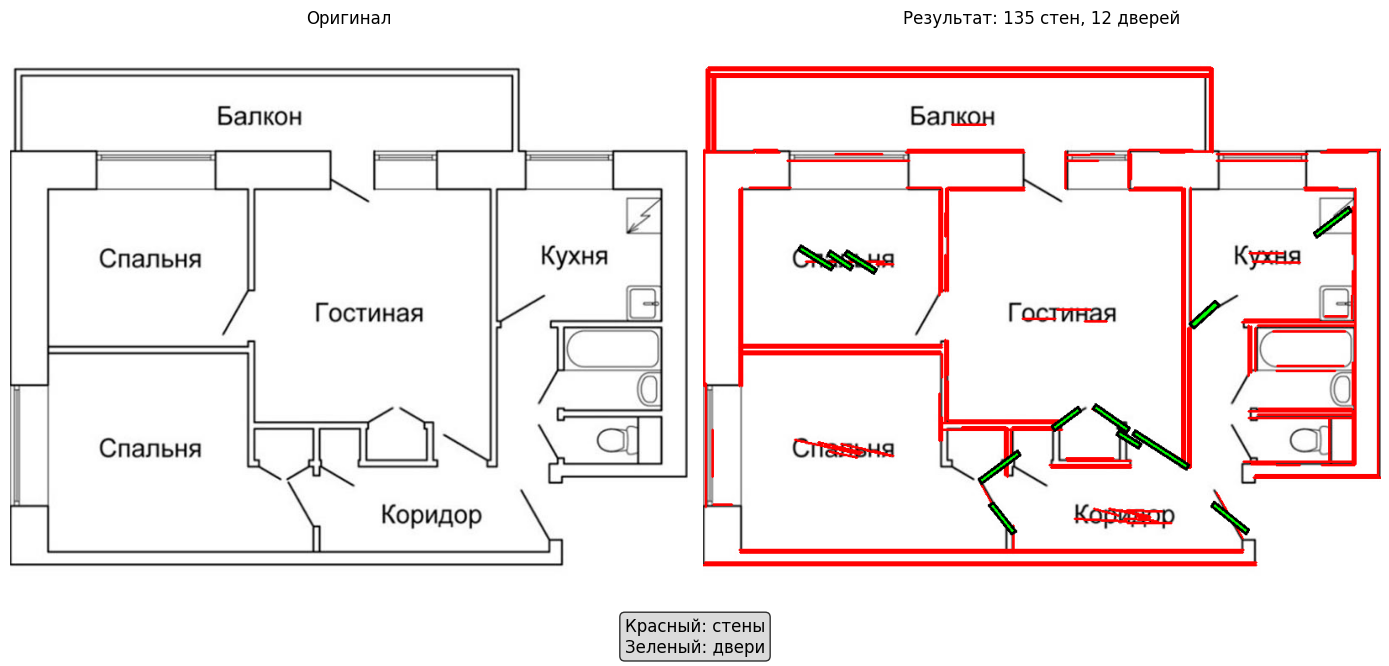

In [83]:
visualize_results(images[1])